In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import nltk
import numpy as np
import re
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, auc, PrecisionRecallDisplay, RocCurveDisplay, mean_squared_error)
from sklearn.dummy import DummyClassifier
from scipy import stats
import pickle

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.0f}'.format

In [3]:
df = pd.read_csv('./../datasets/oal_doc_dataset_extended.csv', 
                 names=['doi', 'pm_grouptype', 'type', 'abstract', 'title', 'page', 'author_count',
                          'has_license', 'is_referenced_by_count',
                          'references_count', 'has_funder', 'country_count', 'inst_count', 'has_oa_url'],
                 dtype={'doi': str,
                        'pm_grouptype': str,
                        'type': str,
                        'abstract': str,
                        'title': str,
                        'page': str,
                        'author_count': int,
                        'has_license': int,
                        'is_referenced_by_count': int,
                        'references_count': int,
                        'has_funder': int,
                        'country_count': int,
                        'inst_count': int,
                        'has_oa_url': int
                 }, sep=',', quotechar='"', header=0)

In [4]:
df_publisher = pd.read_csv('./../datasets/cr_publisher.csv', sep=',')

In [5]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder,country_count,inst_count,has_oa_url
0,10.1001/2012.jama.10425,Journal_Article,research_discourse,NaN,A Path to Wholeness,985,4,0,1,0,0,1,1,0
1,10.1001/2012.jama.10452,Journal_Article,research_discourse,NaN,Worries,873,1,0,1,0,0,1,1,0
2,10.1001/2012.jama.10500,News,editorial_discourse,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0,1,1,0
3,10.1001/2012.jama.10931,Editorial,editorial_discourse,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0,1,1,0
4,10.1001/2012.jama.10939,News,editorial_discourse,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0,1,1,0


In [6]:
def page_counter(page_str):
    page_int = 1
    if '-' in str(page_str):
        try:
            page_str = re.sub(r'(\.e)[\d]*', '', page_str)
            page_str = re.sub(r'(\.)[\d]*', '', page_str)
            page_str = re.sub(r'(?<=\d)(e)(\d)*', '', page_str)
            page_str = re.sub(r'[^\d-]', '', page_str)
            #page_str = re.sub(r'(S)[\d]-', '', page_str)
            page_int = int(abs(eval(page_str)))
            page_int += 1
        except:
            pass
        
    return page_int

In [7]:
df['page_count'] = df.page.apply(page_counter)
df['page_count'] = df['page_count'].astype(int)

In [8]:
df['title_word_length'] = df['title'].str.split().str.len()
#df['abstract_word_length']  = df['abstract'].str.split().str.len()

In [9]:
#df['title_string_length']  = df['title'].str.len()
#df['abstract_string_length']  = df['abstract'].str.len()

In [10]:
def has_abstract(abstract_str):
    if pd.isna(abstract_str):
        return 0
    else:
        return 1

In [11]:
df['has_abstract'] = df.abstract.apply(has_abstract)
df['has_abstract'] = df['has_abstract'].astype(int)

In [12]:
#df['title_string_length'] = df['title_string_length'].fillna(0)
#df['abstract_string_length'] = df['abstract_string_length'].fillna(0)
df['title_word_length'] = df['title_word_length'].fillna(0)
#df['abstract_word_length'] = df['abstract_word_length'].fillna(0)

In [13]:
df = df[df['type'] != 'not assigned']
df['type'] = df['type'].replace(to_replace='research_discourse', value=1)
df['type'] = df['type'].replace(to_replace='editorial_discourse', value=0)
df['type'] = df['type'].astype(int)
df = df.reset_index(drop=True)

In [14]:
#df = df[(np.abs(stats.zscore(df[['author_count', 
#                                 'is_referenced_by_count', 
#                                 'references_count', 
#                                 'page_count', 
#                                 'title_word_length']])) < 3).all(axis=1)]

In [15]:
df_with_publisher = df.merge(df_publisher, on=['doi'])

In [16]:
df_pub_n = df_with_publisher.groupby(['publisher'])['doi'].count().reset_index().sort_values(by=['doi'], ascending=False)
df_pub_n.columns = ['publisher', 'n']

In [17]:
df_pub_n = df_pub_n[df_pub_n.n > 5000]
df = df_with_publisher.merge(df_pub_n, on=['publisher'])

In [18]:
#df.drop_duplicates(subset=['type', 'author_count', 'has_license', 'is_referenced_by_count',
#                           'references_count', 'has_funder', 'page_count', 'has_abstract', 
#                           'title_word_length', 'has_oa_url', 'country_count'], ignore_index=True, inplace=True)
#len(df)

In [19]:
X = df[['doi', 'author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'inst_count', 'has_oa_url']].values
y = df[['type']].values.ravel()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [21]:
test_df = pd.DataFrame(X_test, columns=['doi', 'author_count', 'has_license', 'is_referenced_by_count',
                                        'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'inst_count', 'has_oa_url'])
X = np.delete(X, 0, 1)
X_train = np.delete(X_train, 0, 1)
X_test = np.delete(X_test, 0, 1)

## LogisticRegression

In [71]:
classifier = LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1)
classifier.fit(X_train, y_train)
 
y_pred = classifier.predict(X_test)

In [72]:
print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.59      0.30      0.39    169709
 research_discourse       0.95      0.98      0.96   2121196

           accuracy                           0.93   2290905
          macro avg       0.77      0.64      0.68   2290905
       weighted avg       0.92      0.93      0.92   2290905



## OpenAlex

In [27]:
df_oal_test = pd.read_csv('./../datasets/oal_doctype_testset.csv')
df_oal_test = df_oal_test[df_oal_test['oaltype'] != 'not assigned']
df_oal_test = df_oal_test.reset_index(drop=True)

In [28]:
df_oal_test = df[['doi', 'type']].merge(df_oal_test, on=['doi'])
#df_oal_test = test_df[['doi']].merge(df_oal_test, on=['doi'])

In [29]:
df_oal_test['oaltype'] = df_oal_test['oaltype'].replace(to_replace='research_discourse', value=1)
df_oal_test['oaltype'] = df_oal_test['oaltype'].replace(to_replace='editorial_discourse', value=0)
#df_oal_test['oaltype'] = df_oal_test['oaltype'].replace(to_replace='not assigned', value=0)

In [30]:
y_pm = df_oal_test[['type']].values.ravel()
y_oal = df_oal_test[['oaltype']].values.ravel()

In [31]:
print(classification_report(y_pm, y_oal, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.90      0.05      0.10    678783
 research_discourse       0.93      1.00      0.96   8484193

           accuracy                           0.93   9162976
          macro avg       0.91      0.53      0.53   9162976
       weighted avg       0.93      0.93      0.90   9162976



## Scopus

In [32]:
df_scp_test = pd.read_csv('./../datasets/scp_doctype_testset.csv')
df_scp_test = df_scp_test[df_scp_test['scptype'] != 'not assigned']
df_scp_test = df_scp_test.reset_index(drop=True)

In [33]:
df_scp_test = df[['doi', 'type']].merge(df_scp_test, on=['doi'])
#df_scp_test.drop_duplicates(subset='doi', keep='last', inplace=True, ignore_index=False)
#df_scp_test = test_df[['doi']].merge(df_scp_test, on=['doi'])

In [34]:
df_scp_test['scptype'] = df_scp_test['scptype'].replace(to_replace='research_discourse', value=1)
df_scp_test['scptype'] = df_scp_test['scptype'].replace(to_replace='editorial_discourse', value=0)
#df_scp_test['scptype'] = df_scp_test['scptype'].replace(to_replace='not assigned', value=0)

In [35]:
y_spm = df_scp_test[['type']].values.ravel()
y_scp = df_scp_test[['scptype']].values.ravel()

In [36]:
print(classification_report(y_spm, y_scp, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.65      0.87      0.74    484580
 research_discourse       0.99      0.97      0.98   8368071

           accuracy                           0.97   8852651
          macro avg       0.82      0.92      0.86   8852651
       weighted avg       0.97      0.97      0.97   8852651



## Dummy

In [37]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X, y)

y_pred = dummy_clf.predict(X)
print(classification_report(y, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.07      0.07      0.07    678835
 research_discourse       0.93      0.93      0.93   8484785

           accuracy                           0.86   9163620
          macro avg       0.50      0.50      0.50   9163620
       weighted avg       0.86      0.86      0.86   9163620



In [38]:
## RandomForest

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='gini', max_depth=None, max_features='sqrt', n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
 
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.65      0.61      0.63    169709
 research_discourse       0.97      0.97      0.97   2121196

           accuracy                           0.95   2290905
          macro avg       0.81      0.79      0.80   2290905
       weighted avg       0.95      0.95      0.95   2290905



In [40]:
importances = clf.feature_importances_

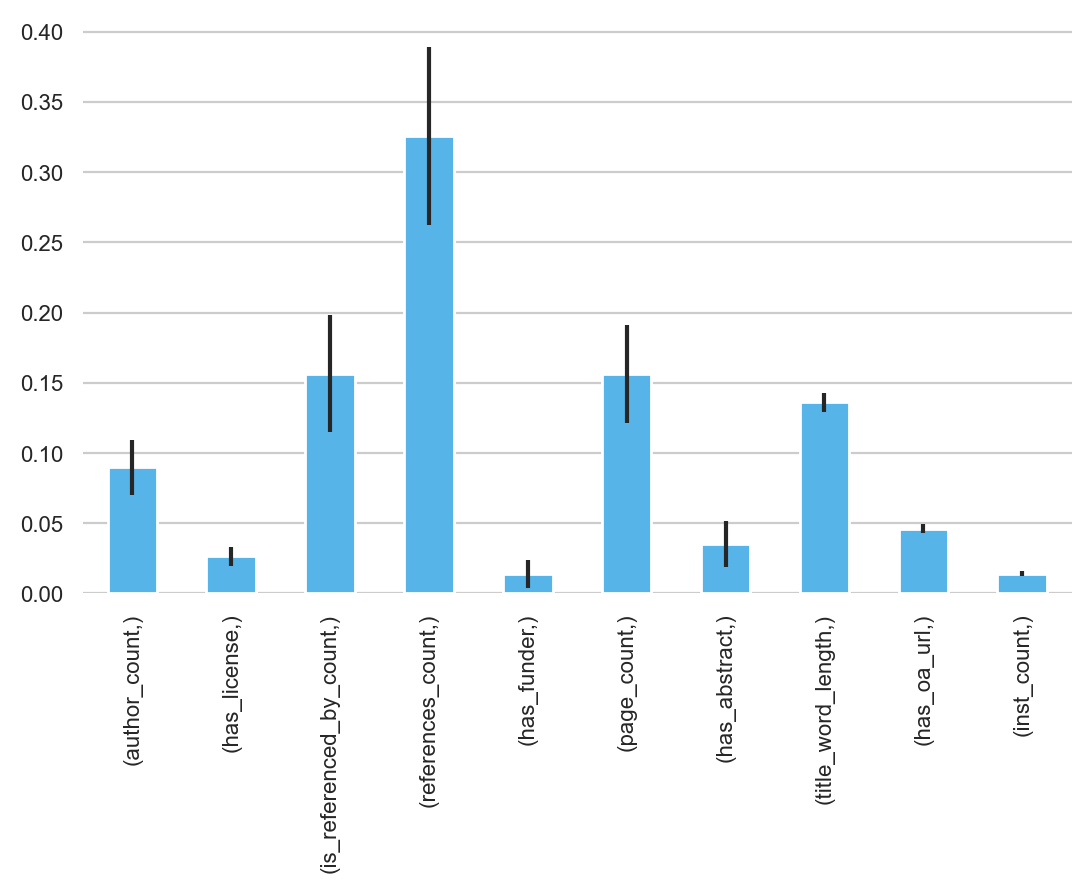

In [41]:
forest_importances = pd.Series(importances, index=[['author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'inst_count']])
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(5.5,4.5))
plt.box(False)
forest_importances.plot.bar(yerr=std, ax=ax, color='#56B4E9')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()

## KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50, 
                           weights='uniform', 
                           algorithm='auto',
                           leaf_size=30, 
                           p=1, 
                           n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.66      0.62      0.64    169709
 research_discourse       0.97      0.97      0.97   2121196

           accuracy                           0.95   2290905
          macro avg       0.81      0.80      0.80   2290905
       weighted avg       0.95      0.95      0.95   2290905



In [44]:
#cv = KFold(n_splits=10, random_state=42, shuffle=True)
#scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [45]:
#from numpy import mean, std
#print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [46]:
#scores

In [47]:
elsevier = df_with_publisher[df_with_publisher.publisher == 'Elsevier BV']
wiley = df_with_publisher[df_with_publisher.publisher == 'Wiley']
springer = df_with_publisher[df_with_publisher.publisher == 'Springer Science and Business Media LLC']
ovid = df_with_publisher[df_with_publisher.publisher == 'Ovid Technologies (Wolters Kluwer Health)']
ama = df_with_publisher[df_with_publisher.publisher == 'American Medical Association (AMA)']
oup = df_with_publisher[df_with_publisher.publisher == 'Oxford University Press (OUP)']
mdpi = df_with_publisher[df_with_publisher.publisher == 'MDPI AG']
informa = df_with_publisher[df_with_publisher.publisher == 'Informa UK Limited']

In [48]:
pd.reset_option('float_format')

In [49]:
elsevier[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               6.272714
has_license                0.980634
is_referenced_by_count    26.138373
references_count          43.259169
has_funder                 0.426146
page_count                 6.620940
has_abstract               0.000057
title_word_length         13.978405
has_oa_url                 0.400218
country_count              1.326891
dtype: float64

In [50]:
wiley[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               6.017189
has_license                0.993537
is_referenced_by_count    22.025914
references_count          43.526910
has_funder                 0.425256
page_count                 7.979971
has_abstract               0.819688
title_word_length         13.827747
has_oa_url                 0.494120
country_count              1.372285
dtype: float64

In [51]:
informa[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               5.308249
has_license                0.240578
is_referenced_by_count    14.674931
references_count          40.300729
has_funder                 0.266618
page_count                 9.245594
has_abstract               0.006632
title_word_length         14.067645
has_oa_url                 0.476161
country_count              1.292065
dtype: float64

In [52]:
springer[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               6.895645
has_license                0.938712
is_referenced_by_count    26.685477
references_count          43.045107
has_funder                 0.324052
page_count                 5.621007
has_abstract               0.288319
title_word_length         14.194463
has_oa_url                 0.650204
country_count              1.336377
dtype: float64

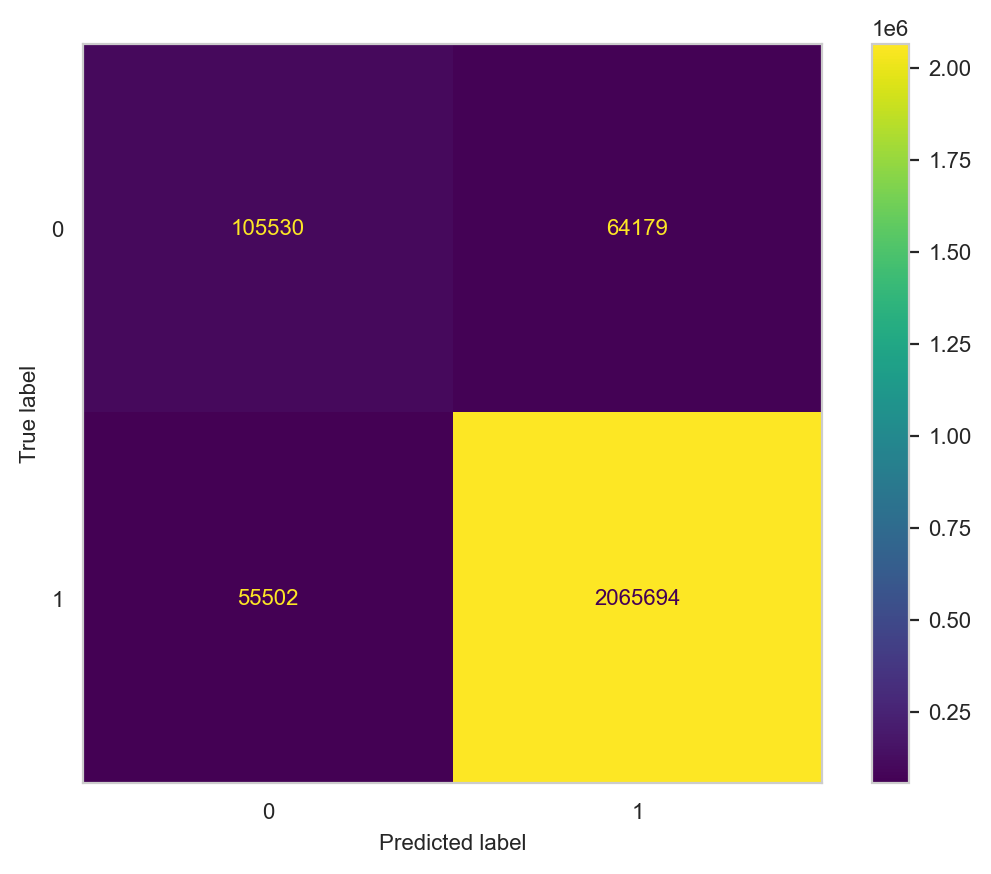

In [53]:
# y_pred = knn.predict(X)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                              display_labels=[0, 1])
disp.plot(values_format='d')
plt.grid(False)
plt.show()

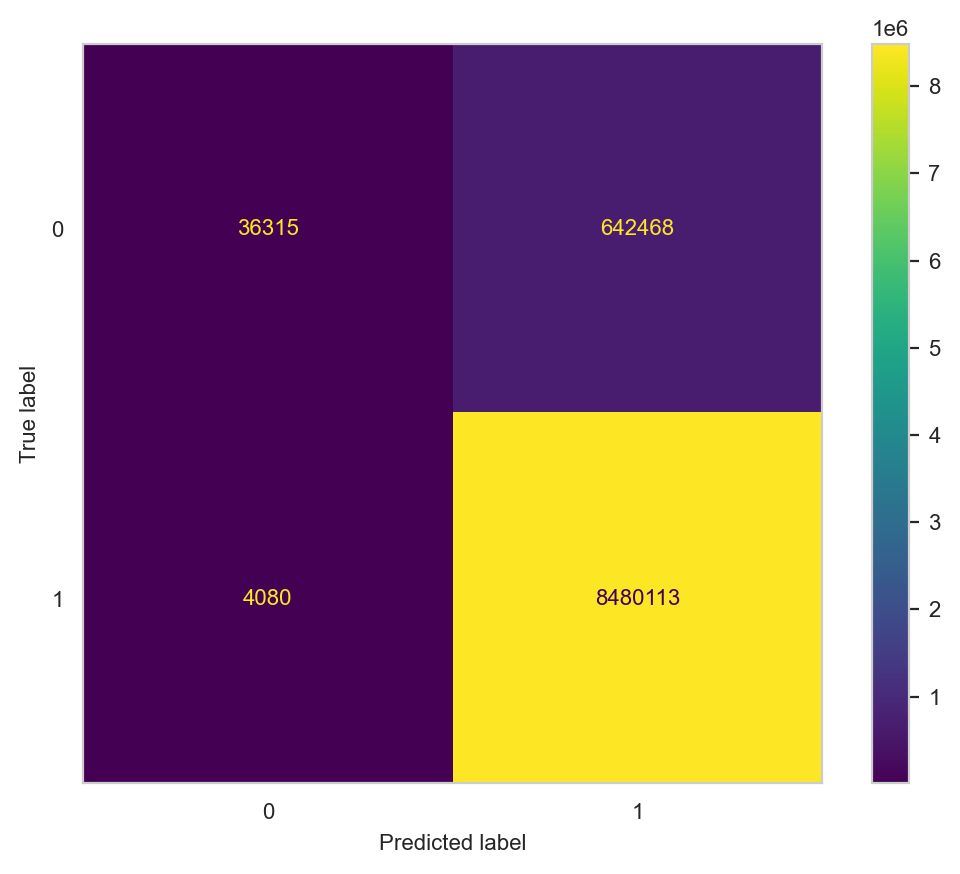

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pm, y_oal))
disp.plot(values_format='d')
plt.grid(False)
plt.show()

In [65]:
y_pred = (knn.predict_proba(X_test)[:,1] >= 0.55).astype(bool)

In [66]:
print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.63      0.68      0.66    169709
 research_discourse       0.97      0.97      0.97   2121196

           accuracy                           0.95   2290905
          macro avg       0.80      0.82      0.81   2290905
       weighted avg       0.95      0.95      0.95   2290905



In [55]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred)

In [56]:
print(auc(fpr, tpr))

0.7978318518066416


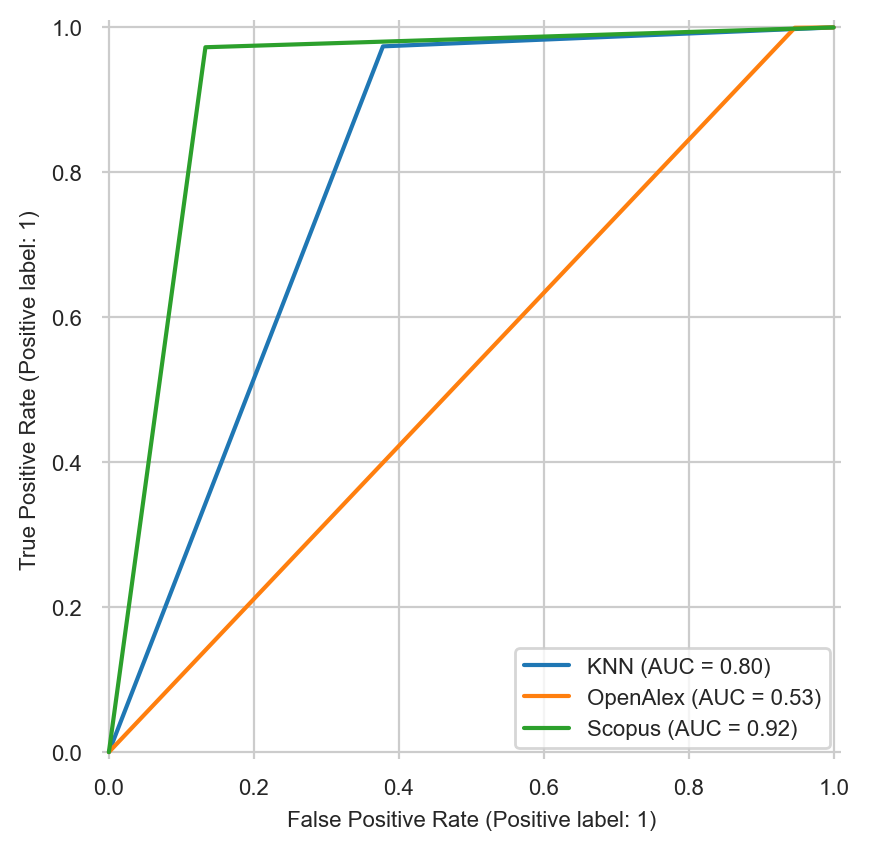

In [57]:
ax = plt.gca()
RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, name='KNN')
RocCurveDisplay.from_predictions(y_pm, y_oal, ax=ax, name='OpenAlex')
RocCurveDisplay.from_predictions(y_spm, y_scp, ax=ax, name='Scopus')

plt.box(False)

plt.show()

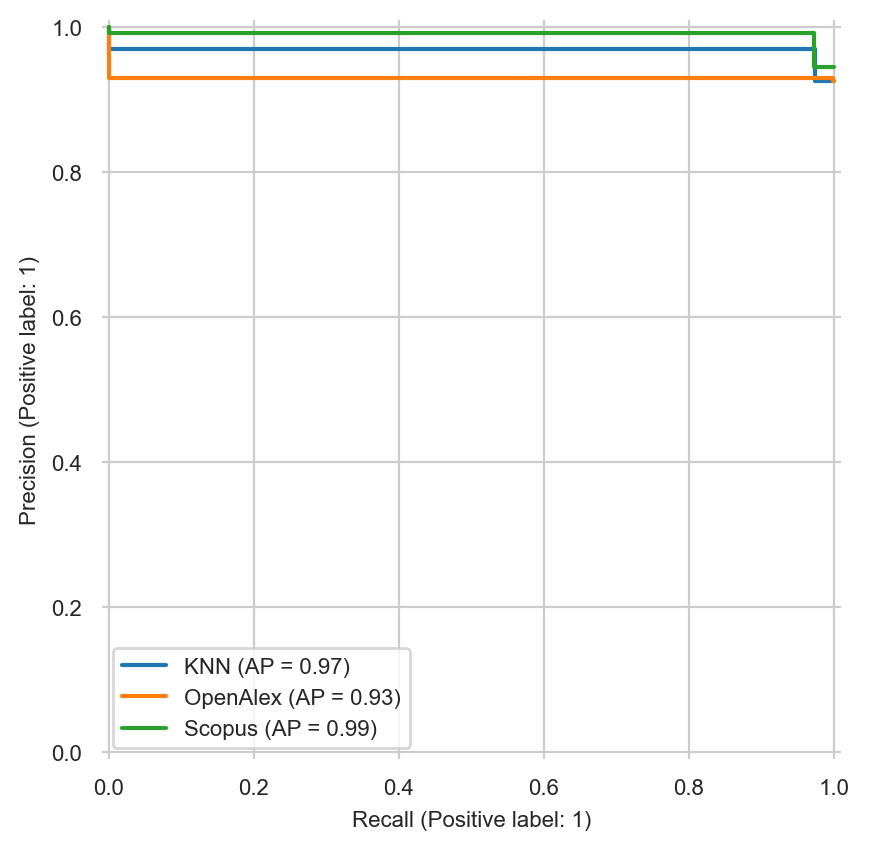

In [58]:
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax, name='KNN')
PrecisionRecallDisplay.from_predictions(y_pm, y_oal, ax=ax, name='OpenAlex')
PrecisionRecallDisplay.from_predictions(y_spm, y_scp, ax=ax, name='Scopus')

plt.box(False)

plt.show()

In [59]:
mean_squared_error(y_test, y_pred)

0.05224179963813427

In [60]:
df[df.page_count > 1000].head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder,country_count,inst_count,has_oa_url,page_count,title_word_length,has_abstract,publisher,n
295642,10.1002/cncr.30009,Journal_Article,1,<jats:sec><jats:title>BACKGROUND</jats:title><...,Comparative effectiveness of stereotactic radi...,2091-100,13,1,50,18,1,1,9,1,1992,21.0,1,Wiley,974624
350957,10.1002/elps.201200658,Journal_Article,1,<jats:p>Quantitative analysis of site‐specific...,<b><scp>LC‐MS</scp></b>3 quantification of <i>...,2342-4349,4,1,21,28,0,2,3,1,2008,7.0,1,Wiley,974624
1033944,10.1111/ped.13142,Case_Reports,1,<jats:title>Abstract</jats:title><jats:p>Insul...,Double pancreatic tumors in an adolescent: Ima...,1239-12342,5,1,0,12,0,1,1,0,11104,8.0,1,Wiley,974624
1201876,10.1097/ccm.0b013e318255d754,Letter,0,NaN,Protocol-resistant critical care?,2539-3539,3,0,1,4,0,1,1,0,1001,3.0,0,Ovid Technologies (Wolters Kluwer Health),418598
1212204,10.1097/corr.0000000000001205,Letter,0,NaN,Reply to the Letter to the Editor: The “Cough ...,00-1136,4,0,0,5,0,2,3,1,1137,24.0,0,Ovid Technologies (Wolters Kluwer Health),418598


In [61]:
page_str = 'e1010.e87-e1019e87'

In [62]:
page_str = re.sub(r'(\.e)[\d]*', '', page_str)
page_str = re.sub(r'(\.)[\d]*', '', page_str)
page_str = re.sub(r'(?<=\d)(e)(\d)*', '', page_str)
page_str = re.sub(r'[^\d-]', '', page_str)

In [63]:
page_str

'1010-1019'

In [64]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder,country_count,inst_count,has_oa_url,page_count,title_word_length,has_abstract,publisher,n
0,10.1001/2012.jama.10425,Journal_Article,1,NaN,A Path to Wholeness,985,4,0,1,0,0,1,1,0,1,4.0,0,American Medical Association (AMA),36486
1,10.1001/2012.jama.10452,Journal_Article,1,NaN,Worries,873,1,0,1,0,0,1,1,0,1,1.0,0,American Medical Association (AMA),36486
2,10.1001/2012.jama.10500,News,0,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0,1,1,0,1,14.0,0,American Medical Association (AMA),36486
3,10.1001/2012.jama.10931,Editorial,0,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0,1,1,0,1,5.0,0,American Medical Association (AMA),36486
4,10.1001/2012.jama.10939,News,0,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0,1,1,0,1,12.0,0,American Medical Association (AMA),36486


In [67]:
test_df['pred'] = y_pred

In [68]:
test_df_with_type = test_df.merge(df[['doi', 'pm_grouptype']], on='doi')

In [69]:
test_df_with_type.groupby(['pm_grouptype', 'pred'])['doi'].agg('count')

pm_grouptype     pred 
Case_Reports     False      12080
                 True       51527
CochraneReview   False          2
                 True        1526
Editorial        False      32531
                 True       21164
Journal_Article  False      50618
                 True     1672809
Letter           False      59470
                 True       24500
News             False       5036
                 True        2063
RCT              False        373
                 True       70029
Retraction       False      16805
                 True        5019
Review           False       1834
                 True      209768
SR_and_MA        False        155
                 True       47469
other_53_types   False       6138
                 True        7064
Name: doi, dtype: int64

In [70]:
with open('model.pkl', 'wb') as f:
    pickle.dump(knn, f)